# Clasificación utilizando XGBoost (Core)


**Objetivo:** Implementar un pipeline completo de machine learning para un problema de clasificación utilizando XGBoost. Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

**Dataset:** Heart Disease UCI

**Descripción del Dataset:** El dataset de enfermedades del corazón de la UCI contiene información sobre varios factores de riesgo asociados con enfermedades cardíacas. El objetivo es predecir la presencia de enfermedad cardíaca basándose en estos factores.


#### **Instrucciones:**

##### **Parte 1: Carga y Exploración Inicial de Datos**

**Carga del Dataset:**
1. Cargar el dataset desde Kaggle.
**Exploración Inicial:**
1. Revisar la estructura del dataset.
2. Describir las variables y su distribución.
3. Identificar y documentar valores faltantes y outliers.


##### **Parte 2: Análisis Exploratorio de Datos (EDA)**

**Análisis Estadístico Descriptivo:**
1. Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
2. Analizar la distribución de las variables categóricas.
**Visualizaciones:**
1. Crear histogramas y gráficos de barras para entender la distribución de las variables.
2. Crear un mapa de calor para visualizar las correlaciones entre las variables.
3. Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.
**Valores Faltantes y Outliers:**
1. Detectar y tratar valores faltantes.
2. Identificar y manejar outliers.


##### **Parte 3: Preprocesamiento de Datos**

**Transformación de Columnas:**
1. Codificar variables categóricas utilizando One-Hot Encoding.
2. Escalar características numéricas utilizando StandardScaler.
**División del Conjunto de Datos:**
1. Dividir el dataset en conjuntos de entrenamiento y prueba.


##### **Parte 4: Implementación de XGBoost**

**Entrenamiento del Modelo:**
1. Entrenar un modelo de XGBoost con hiperparámetros básicos.
2. Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.
**Optimización de Hiperparámetros:**
1. Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de XGBoost.
**Evaluación del Modelo Optimizado:**
1. Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import utils


In [2]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# # metadata
# print(heart_disease.metadata)

# # variable information
# print(heart_disease.variables)

In [3]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [5]:
y.head()

,num
0,0
1,2
2,1
3,0
4,0


In [6]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   num     303 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

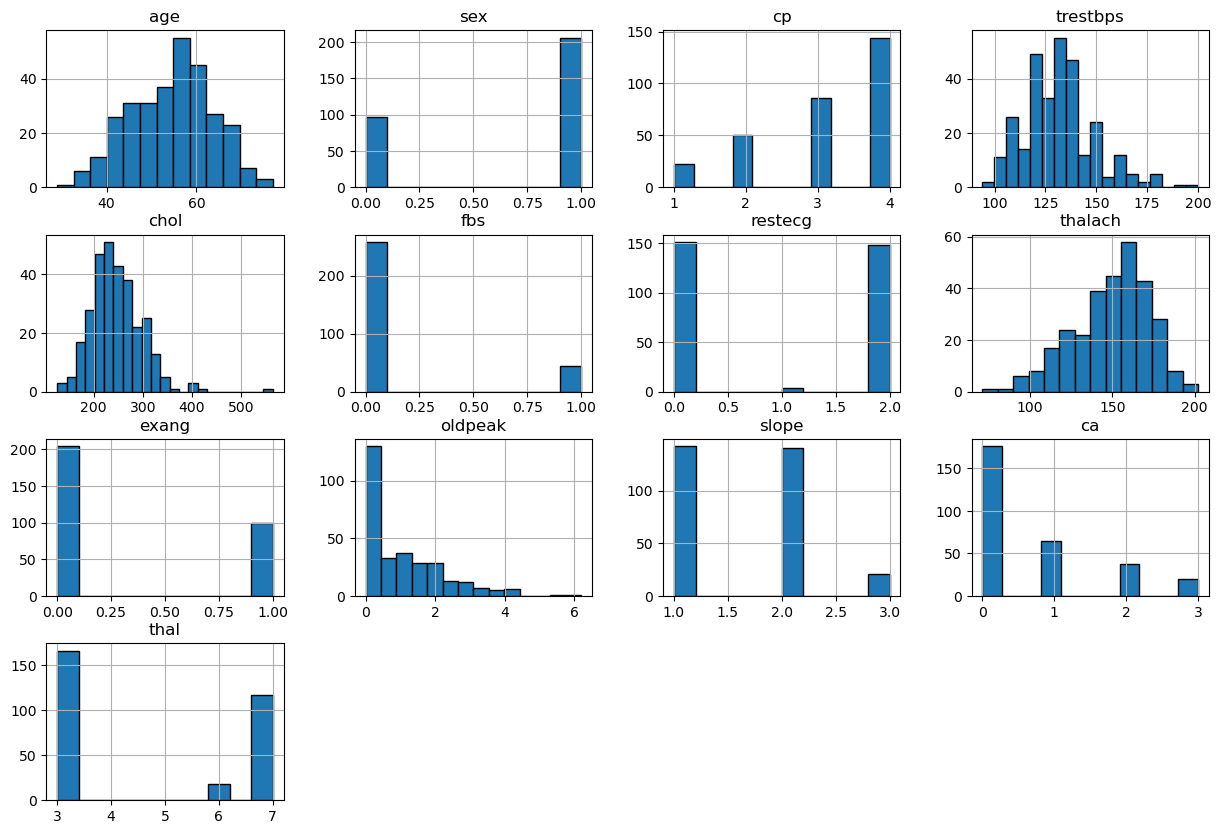

In [7]:
X.hist(bins='auto', figsize=(15, 10), edgecolor='black')

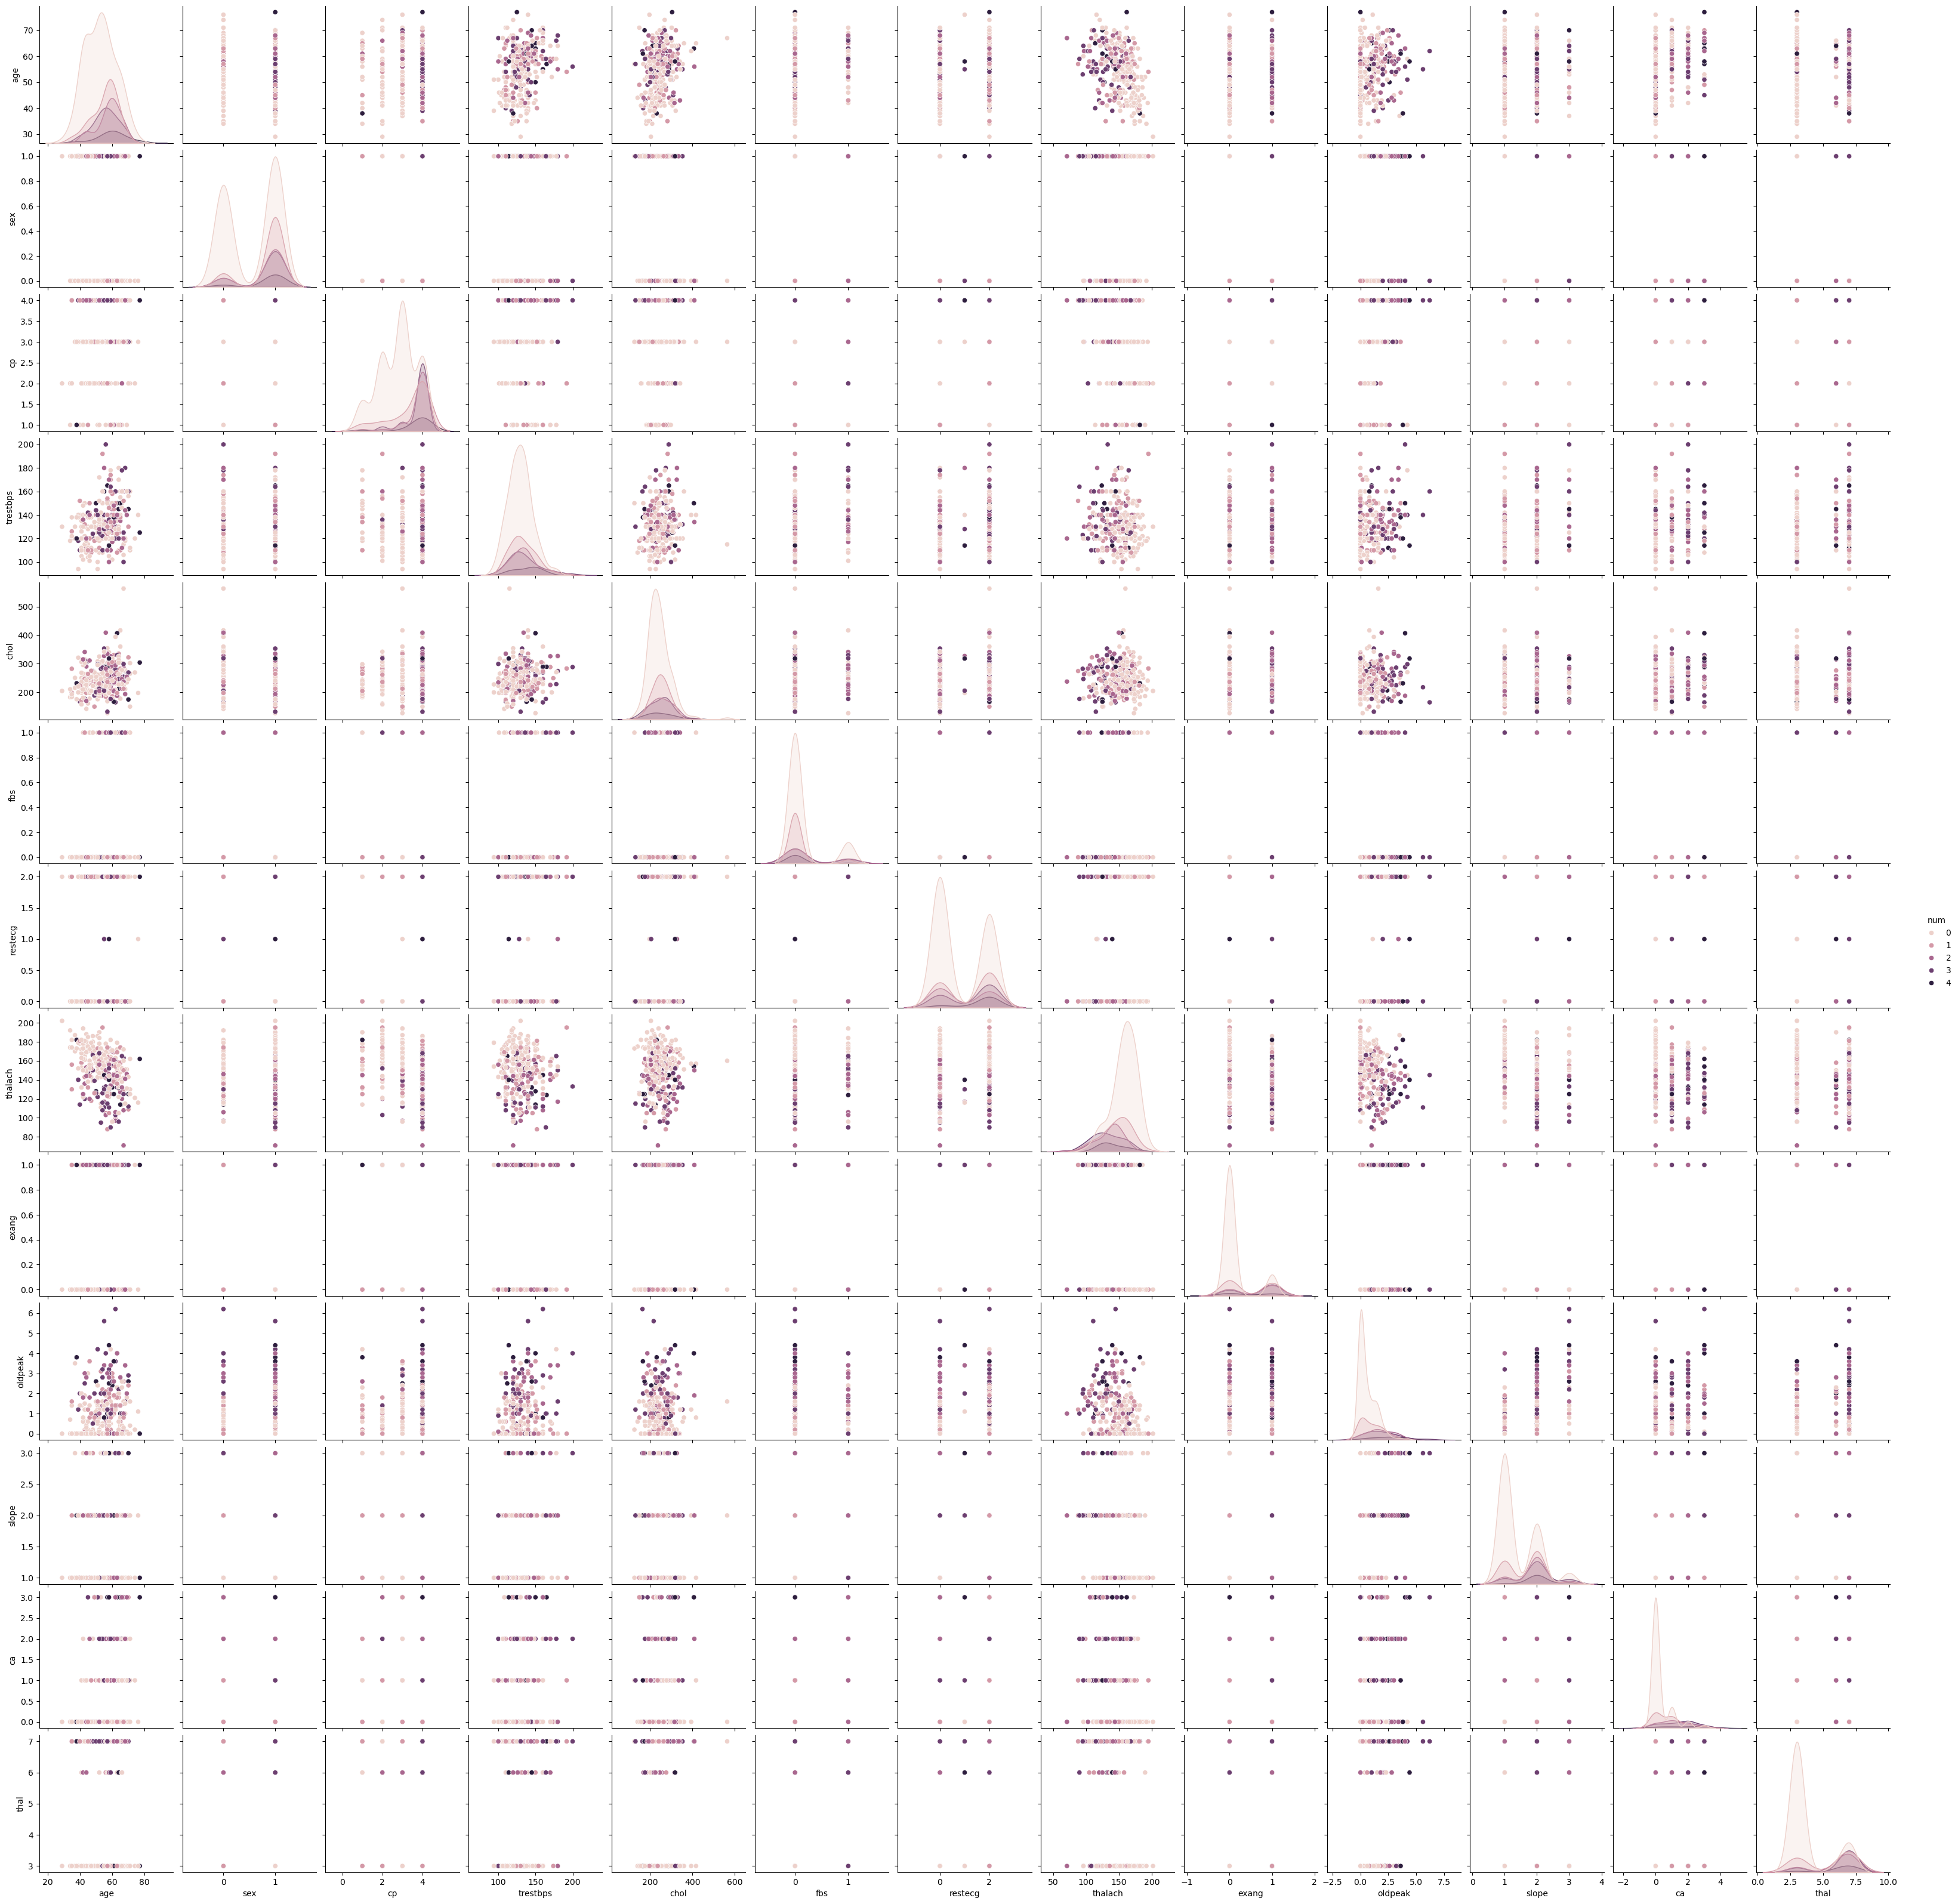

In [8]:
# Concatenar X e y para pasar todo como un único DataFrame a sns.pairplot
datapairplot = pd.concat([X, y], axis=1)

# Crear el pairplot
sns.pairplot(datapairplot, hue='num')


Estadisticas de las variables predictoras

In [9]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in X:
    datos_columna = X[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
age,303.0,54.44,56.0,9.04,29.0,77.0,48.0,61.0
sex,303.0,0.68,1.0,0.47,0.0,1.0,0.0,1.0
cp,303.0,3.16,3.0,0.96,1.0,4.0,3.0,4.0
trestbps,303.0,131.69,130.0,17.60,94.0,200.0,120.0,140.0
chol,303.0,246.69,241.0,51.78,126.0,564.0,211.0,275.0
fbs,303.0,0.15,0.0,0.36,0.0,1.0,0.0,0.0
restecg,303.0,0.99,1.0,0.99,0.0,2.0,0.0,2.0
thalach,303.0,149.61,153.0,22.88,71.0,202.0,133.5,166.0
exang,303.0,0.33,0.0,0.47,0.0,1.0,0.0,1.0
oldpeak,303.0,1.04,0.8,1.16,0.0,6.2,0.0,1.6


Analizamos los Outliers

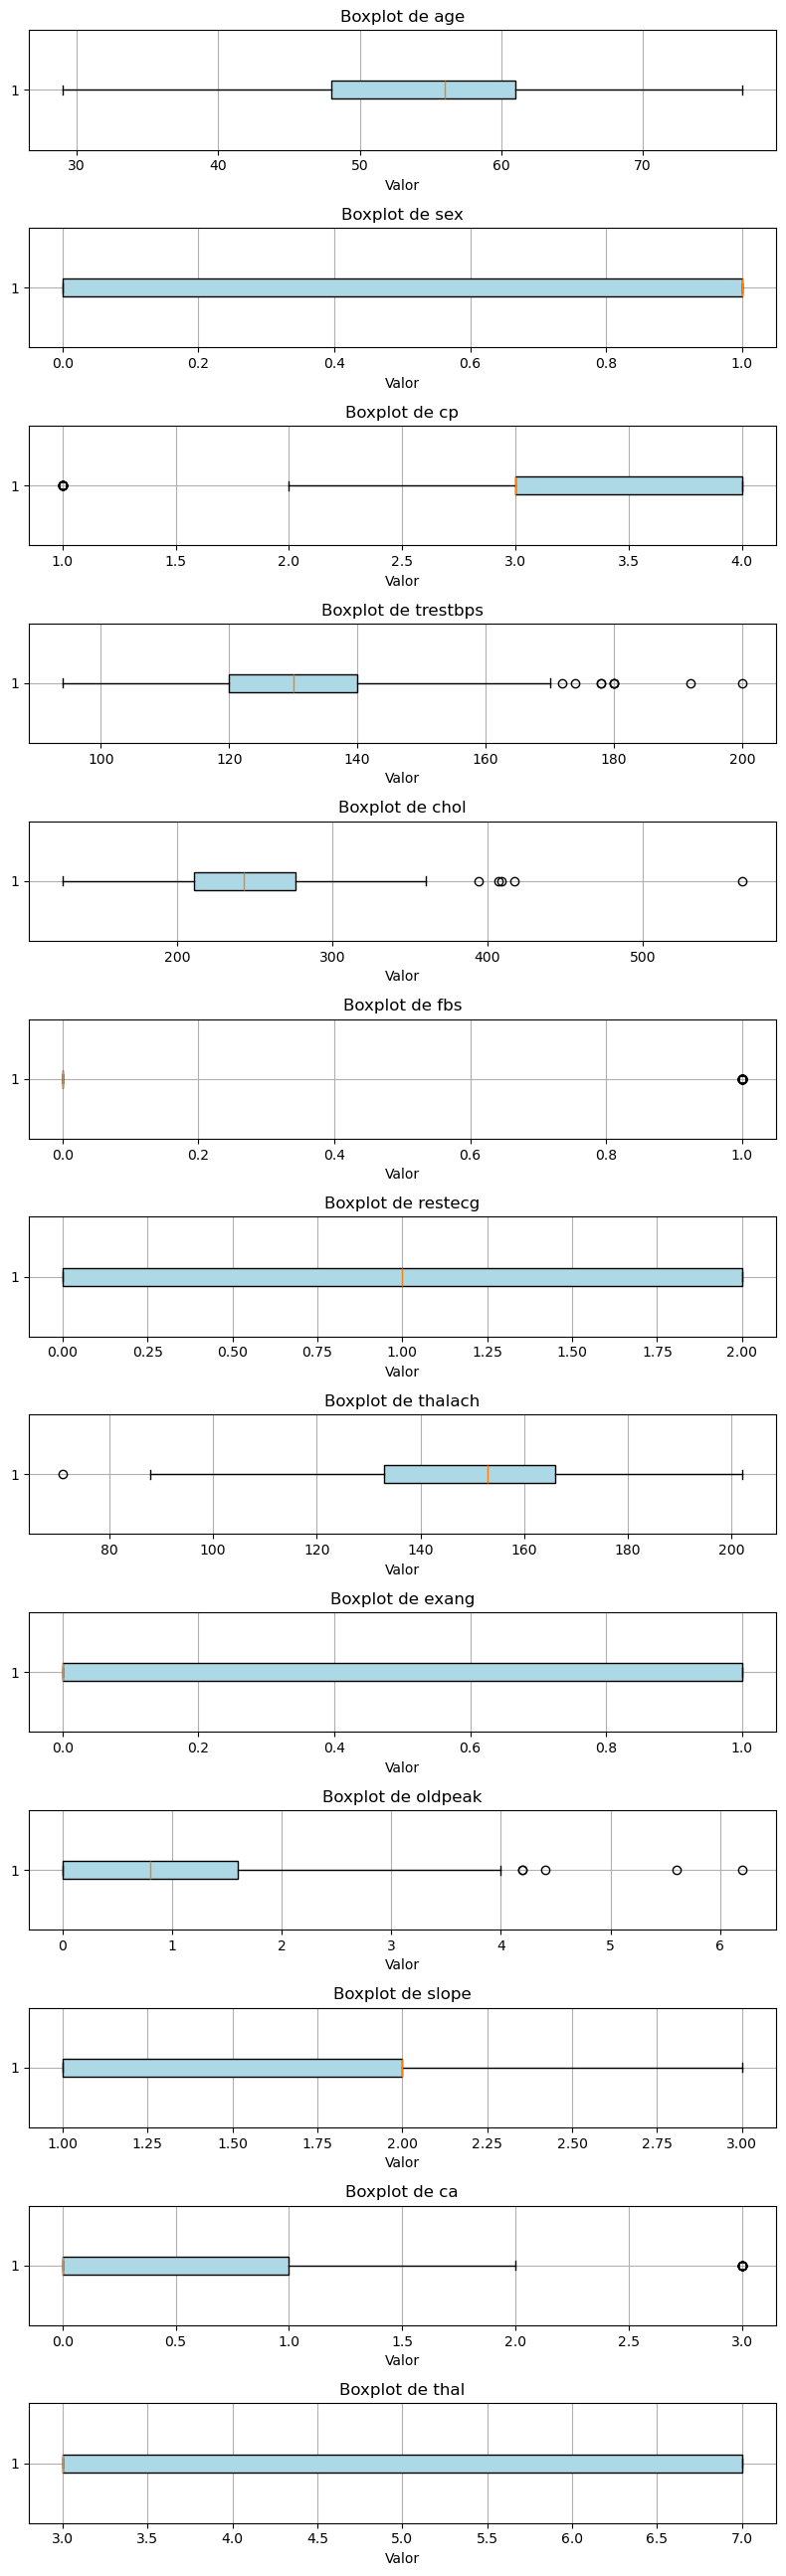

In [10]:
# Crear gráficos de boxplot en una sola columna
fig, axes = plt.subplots(nrows=len(X.dropna().columns), ncols=1, figsize=(8, len(X.dropna().columns) * 2))

# Asegurarse de que axes sea un arreglo, incluso si hay solo un gráfico
if len(X.dropna().columns) == 1:
    axes = [axes]

# Graficar cada variable en un boxplot separado
for i, col in enumerate(X.dropna()):
    axes[i].boxplot(X.dropna()[col], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('Valor')
    axes[i].grid()

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [11]:
outliers_summary = pd.DataFrame()
for column in X:
    outliers = utils.detect_outliers_iqr(X[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': X[column][~outliers].min(),
        'Upper Bound': X[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
age,0.0,0.000000,29.0,77.0
sex,0.0,0.000000,0.0,1.0
cp,23.0,7.590759,2.0,4.0
trestbps,9.0,2.970297,94.0,170.0
chol,5.0,1.650165,126.0,360.0
fbs,45.0,14.851485,0.0,0.0
restecg,0.0,0.000000,0.0,2.0
thalach,1.0,0.330033,88.0,202.0
exang,0.0,0.000000,0.0,1.0
oldpeak,5.0,1.650165,0.0,4.0


Verificamos si existen NaN

In [12]:
utils.calculate_na_statistics(X)

,datos sin NAs en q,Na en q,Na en %
ca,299,4,1.32
thal,301,2,0.66
age,303,0,0.00
sex,303,0,0.00
cp,303,0,0.00
trestbps,303,0,0.00
chol,303,0,0.00
fbs,303,0,0.00
restecg,303,0,0.00
thalach,303,0,0.00


Eliminamos los NaN

In [13]:
# Imprimir la forma original de X y la forma después de eliminar NaN
print(X.shape)
print(X.dropna().shape)

# Eliminar filas con valores NaN de X y mantener el índice original
X_cleaned = X.dropna()

# Eliminar las filas correspondientes en y usando el índice de X_cleaned
y_cleaned = y.loc[X_cleaned.index]

# Asignar los datos limpios de vuelta a X y y
X = X_cleaned
y = y_cleaned

# Imprimir la nueva forma de y
print(y.shape)

(303, 13)
(297, 13)
(297, 1)


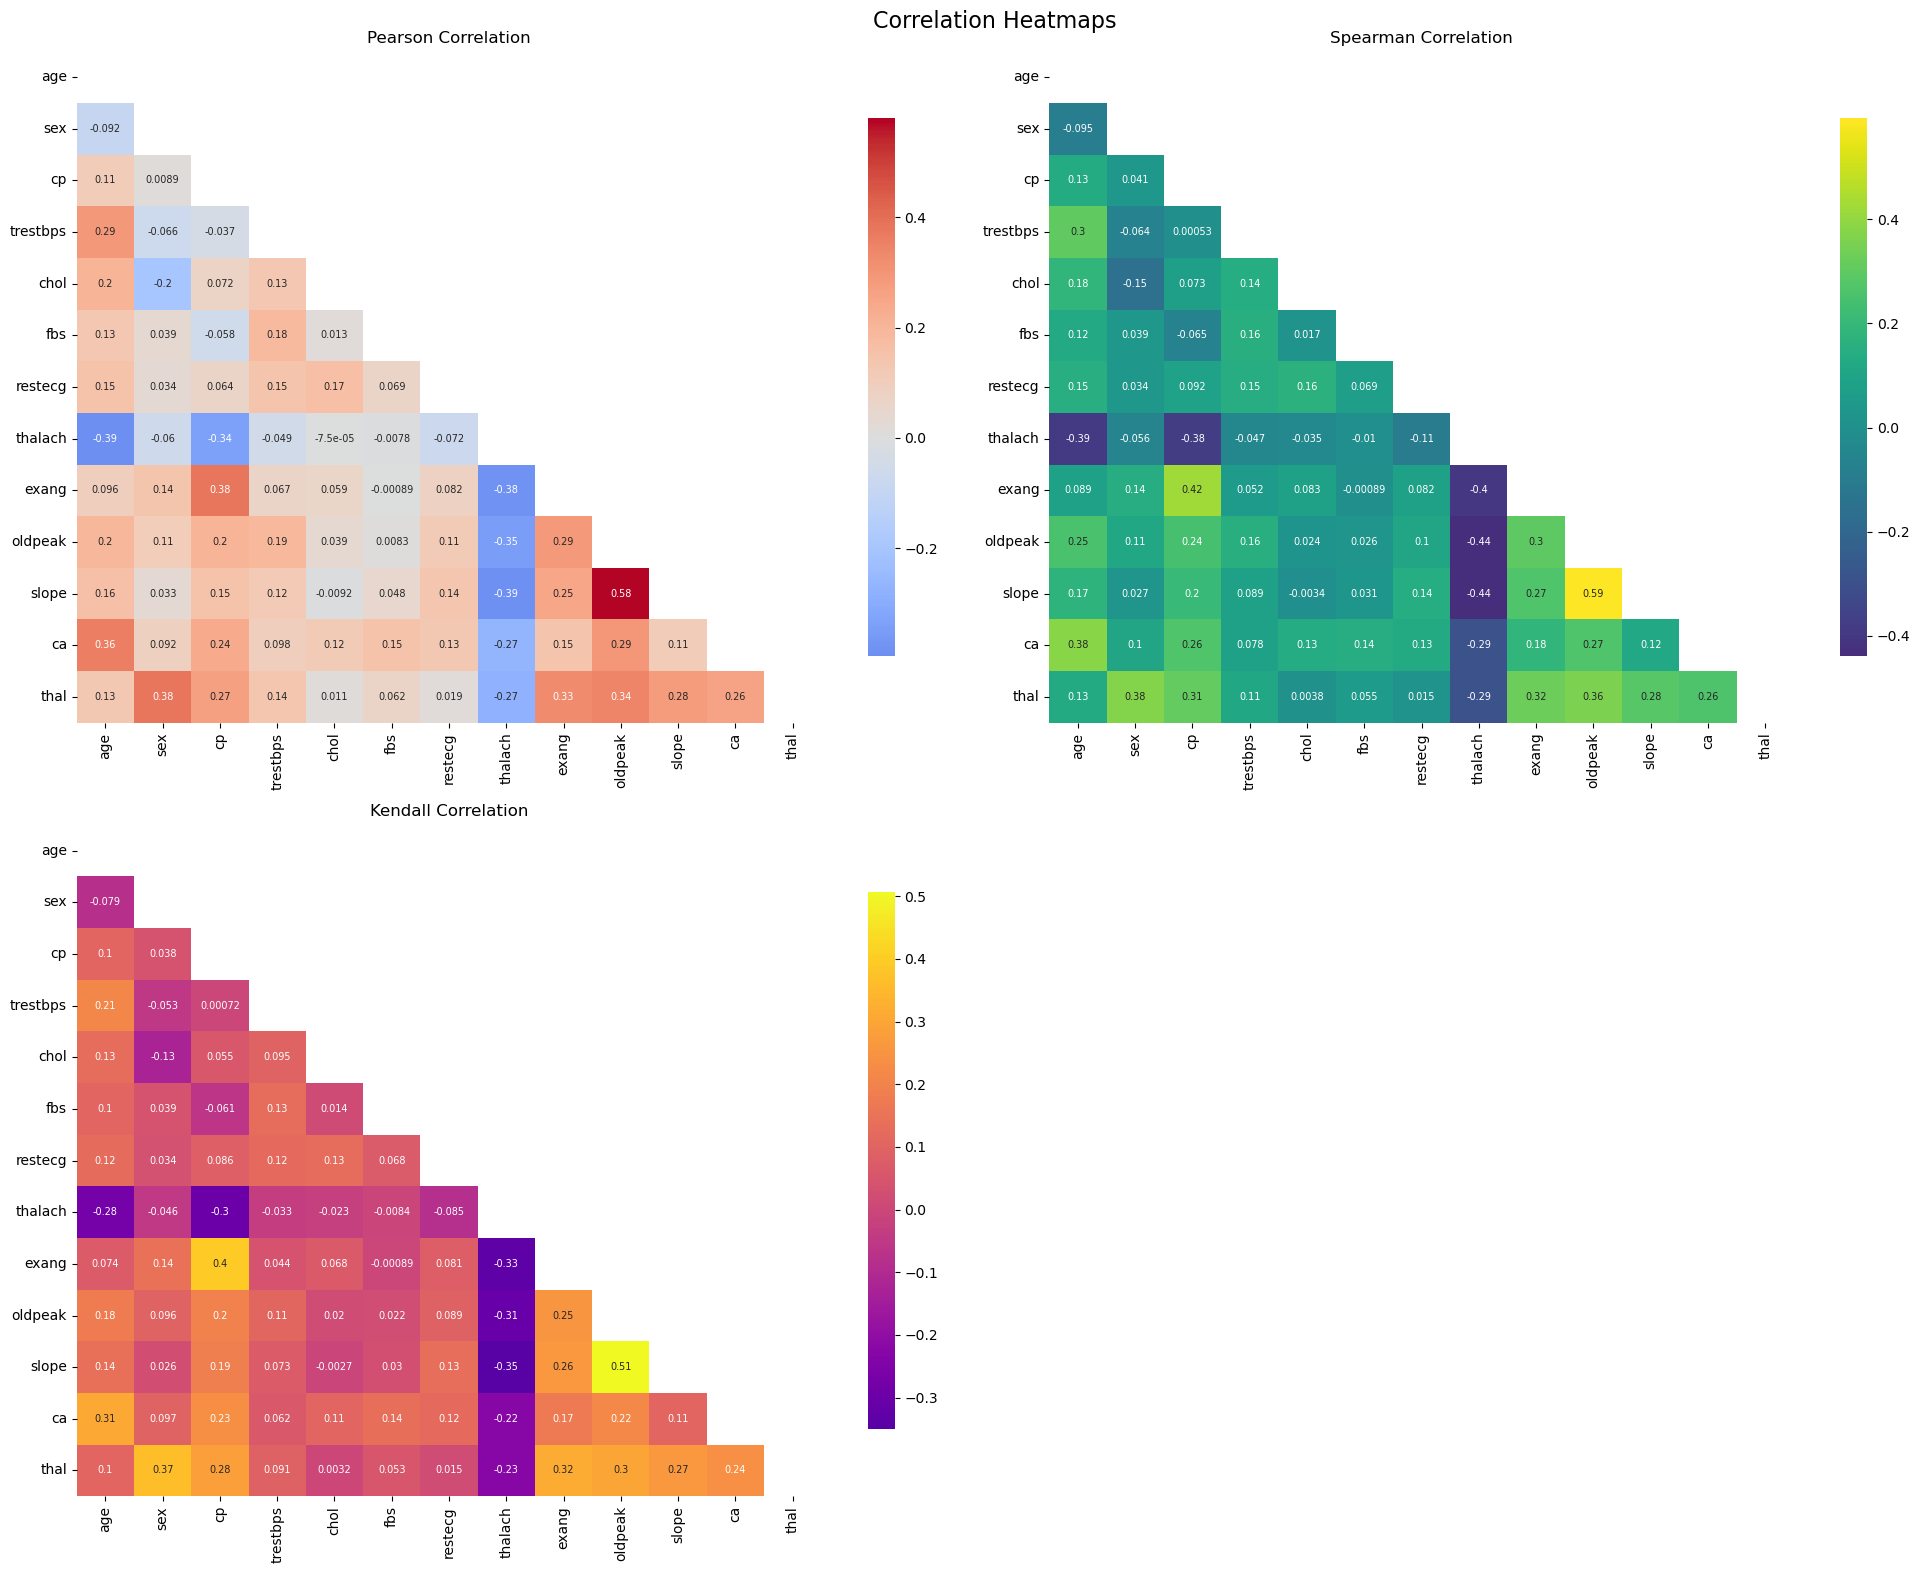

In [14]:
pearson_corr = X.corr(method='pearson')
spearman_corr = X.corr(method='spearman')
kendall_corr = X.corr(method='kendall')

utils.graph_correlations(
    pearson_corr, 
    spearman_corr, 
    kendall_corr, 
    title="Correlation Heatmaps", 
    figsize=(20, 16),
    annot_size=7
)

Convertimos la variable objetivo a binario

In [15]:
# Convertir y en una variable binaria: 0 = sin enfermedad, 1 = con enfermedad
y_binary = np.where(y > 0, 1, 0)

print(np.unique(y_binary))  # Debería mostrar solo [0, 1]

[0 1]


Modeling

In [16]:
# Definimos las columnas categóricas y numéricas
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']



In [17]:
# Parte 2: Preprocesamiento de datos
# Creamos un preprocesador que combine StandardScaler y OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)



In [18]:
# Parte 3: Modelo XGBoost básico
# Crear pipeline con preprocesamiento y modelo
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
    ))
])

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo básico
print("=== Evaluación del Modelo Básico ===")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))



=== Evaluación del Modelo Básico ===
Accuracy: 0.867

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.81      0.88      0.84        24

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.87      0.87      0.87        60


ROC-AUC Score: 0.8680555555555556


In [19]:
# Parte 4: Optimización de hiperparámetros
# Definir espacio de búsqueda
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__min_child_weight': [1, 3]
}

# Crear y ejecutar GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Obtener y evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)

print("\n=== Evaluación del Modelo Optimizado ===")
print("Mejores parámetros:", grid_search.best_params_)
print(f'Accuracy: {accuracy_score(y_test, y_pred_optimized):.3f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_optimized))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred_optimized))


=== Evaluación del Modelo Optimizado ===
Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}
Accuracy: 0.800

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60


ROC-AUC Score: 0.8055555555555556


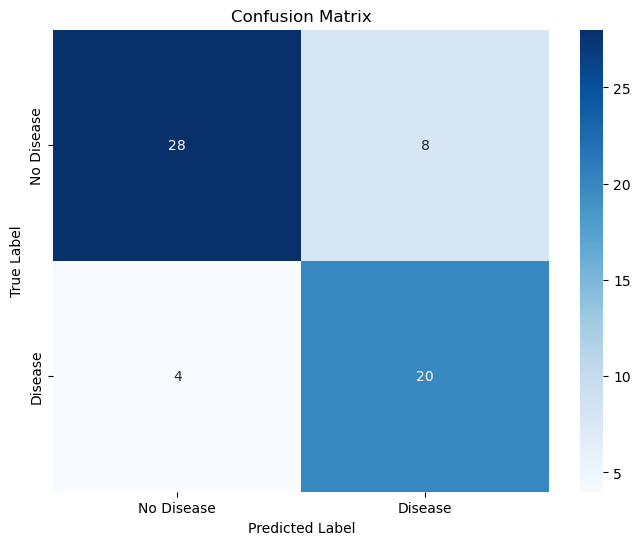

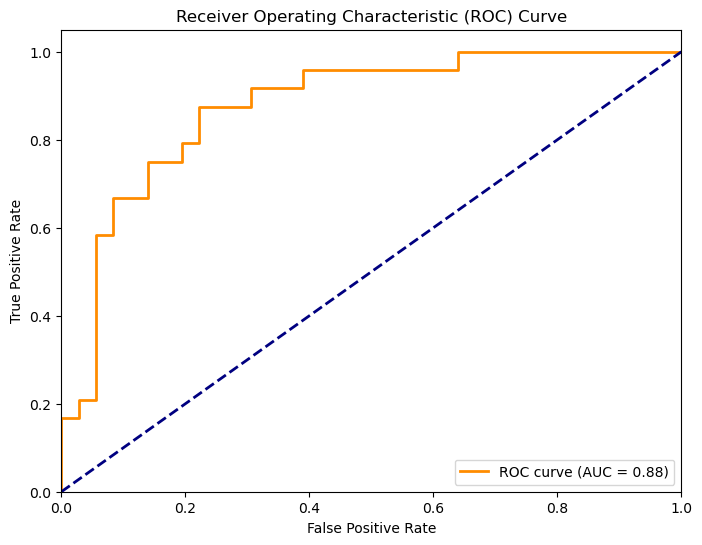

In [20]:
# Función para visualizar la matriz de confusión
def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Función para visualizar la curva ROC
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Para usar las funciones:
# Obtener probabilidades para la curva ROC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Generar los gráficos
plot_confusion_matrix(y_test, y_pred_optimized)
plot_roc_curve(y_test, y_pred_proba)